In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import re
import rasterio
import geopandas as gpd
from rasterio.mask import geometry_mask
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import euclidean
import seaborn as sns
from sklearn.utils import resample
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from scipy.linalg import det, inv

In [2]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

all_image_paths = image_paths + unlabeled_image_paths

def pair_files(all_image_paths, shapefile_paths, walrus_paths):
    file_pairs = {}
    for image_path in all_image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        # Pair with general shapefiles
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None

        # Pair with walrus shapefiles
        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        walrus_shapefile = matching_walrus[0] if matching_walrus else None

        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)

    return file_pairs

file_pairs = pair_files(all_image_paths, shapefile_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, general_shapefile, walrus_shapefile)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

         Coast_blue          Blue        Green1         Green        Yellow  \
count  1.214157e+06  1.214157e+06  1.214157e+06  1.214157e+06  1.214157e+06   
mean   1.193268e+03  1.001146e+03  1.162419e+03  1.036085e+03  1.100564e+03   
std    9.578196e+02  8.984674e+02  9.375207e+02  9.249778e+02  1.025936e+03   
min    1.100000e+02  1.000000e+00  1.660000e+02  1.000000e+00  2.200000e+01   
25%    7.680000e+02  6.250000e+02  6.900000e+02  5.330000e+02  4.690000e+02   
50%    9.100000e+02  7.760000e+02  9.320000e+02  7.920000e+02  8.050000e+02   
75%    1.218000e+03  9.680000e+02  1.207000e+03  1.158000e+03  1.358000e+03   
max    6.719000e+03  6.583000e+03  6.776000e+03  6.693000e+03  6.987000e+03   

                Red      Red_edge           NIR  encoded_labels  
count  1.214157e+06  1.214157e+06  1.214157e+06    1.214157e+06  
mean   8.571543e+02  8.420037e+02  7.726977e+02    1.765604e+00  
std    9.776060e+02  9.958182e+02  1.037295e+03    6.382599e-01  
min    1.000000e+00  1.0

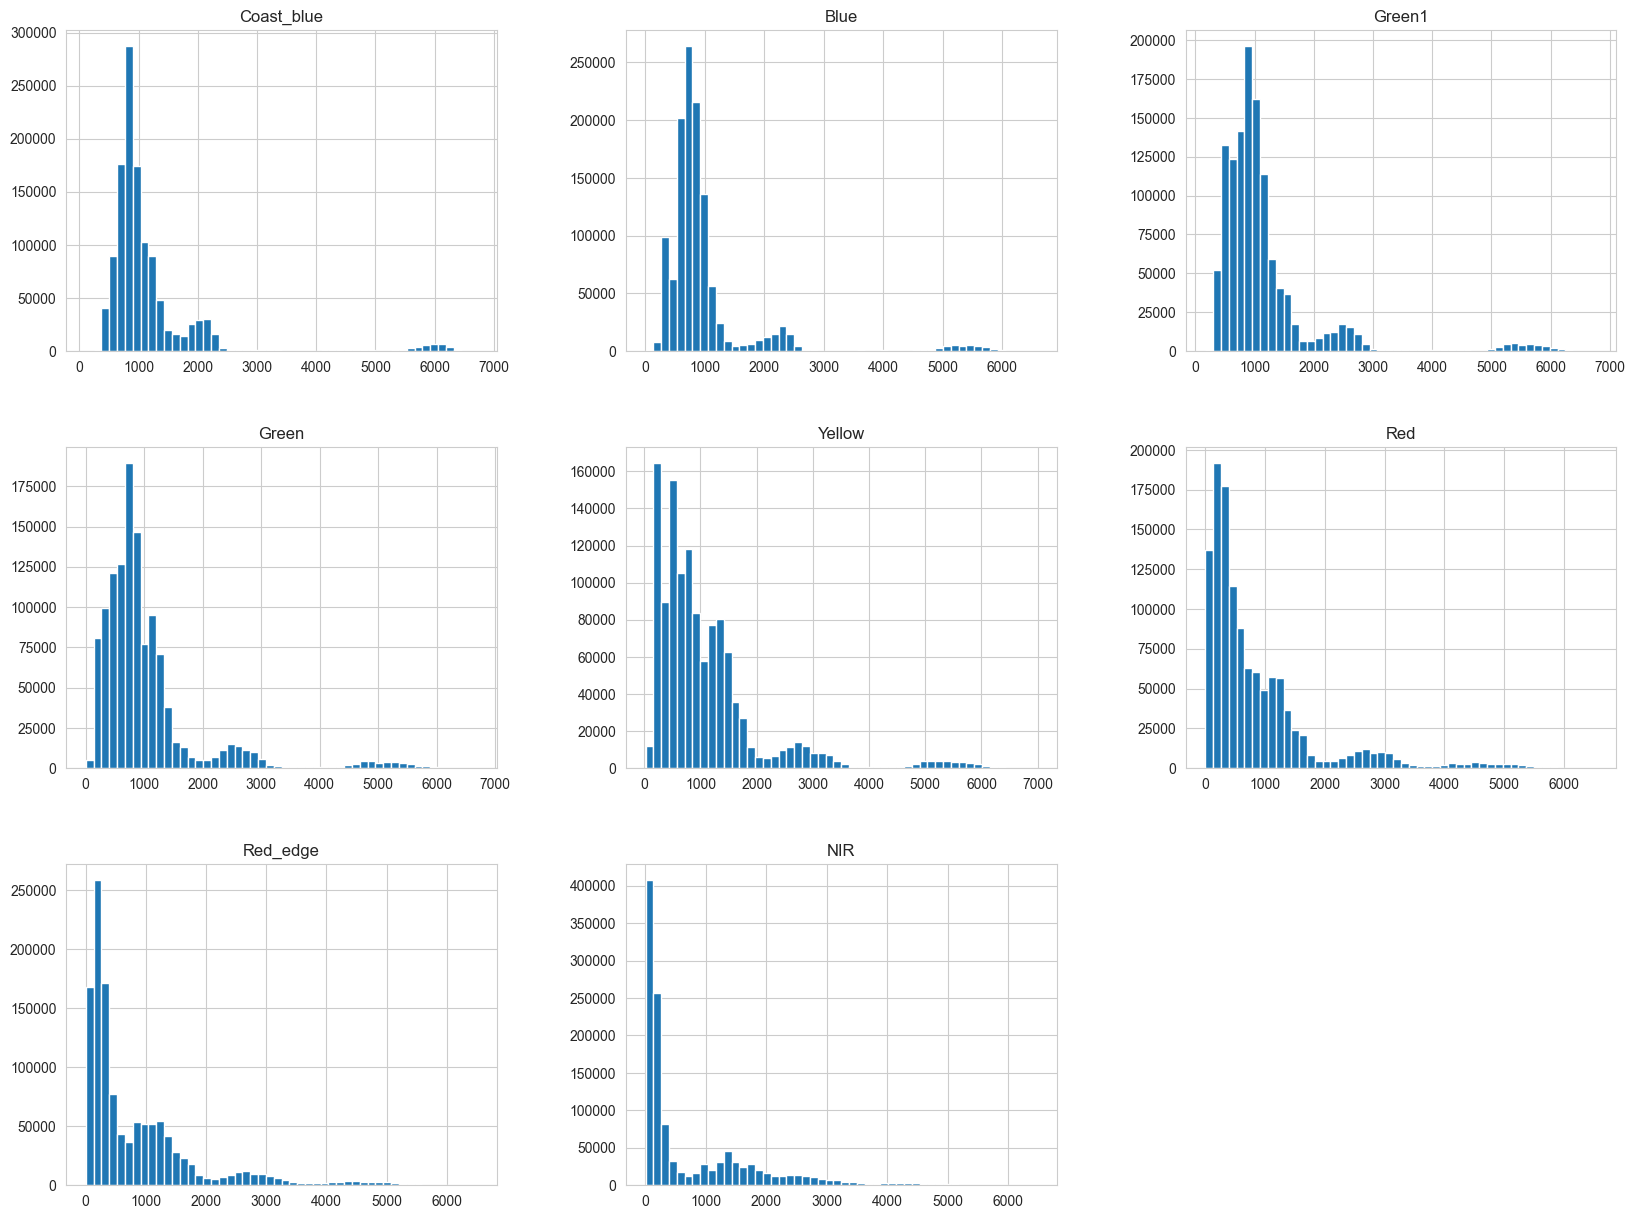

In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Display summary statistics
print(dataset.describe())

# Visualize data distribution
dataset.iloc[:, :8].hist(bins=50, figsize=(20, 15))
plt.show()
